Імпорт бібліотек

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from tqdm import tqdm
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Підготовка даних

In [2]:
df = pd.read_csv('dataset_pcs.csv')

In [3]:
df['period'] = pd.to_datetime(df['period'], errors='coerce')

In [5]:
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
df['qty_total'] = pd.to_numeric(df['qty_total'], errors='coerce')
df['price'] = df.apply(lambda row: row['revenue'] / row['qty_total'] if row['qty_total'] != 0 else 0, axis=1)

In [6]:
forecast_dates = pd.to_datetime(['2025-02-03', '2025-02-10', '2025-02-17', '2025-02-24'])

Виділення тренувального періоду і тестового періоду

In [7]:
cutoff_date = pd.to_datetime('2025-01-31')
train_df = df[df['period'] <= cutoff_date]
test_df = df[df['period'].isin(forecast_dates)]

Запуск моделі

In [8]:
sku_ids = train_df['sku_id'].unique()
forecast_results = []

for sku in tqdm(sku_ids, desc='Forecasting SKUs'):
    sku_train = train_df[train_df['sku_id'] == sku][['period', 'qty_total']].rename(columns={'period': 'ds', 'qty_total': 'y'})
    
    # Skip SKUs with insufficient data
    if sku_train['y'].count() < 10 or sku_train['y'].nunique() <= 1:
        continue

    model = Prophet(daily_seasonality=True)
    try:
        model.fit(sku_train)
        future = pd.DataFrame({'ds': forecast_dates})
        forecast = model.predict(future)[['ds', 'yhat']]
        forecast['sku_id'] = sku
        forecast_results.append(forecast)
    except Exception as e:
        print(f"⚠️ Skipped SKU {sku}: {e}")
        continue


forecast_df = pd.concat(forecast_results, ignore_index=True)

Forecasting SKUs:   0%|          | 0/463 [00:00<?, ?it/s]16:08:28 - cmdstanpy - INFO - Chain [1] start processing
16:08:28 - cmdstanpy - INFO - Chain [1] done processing
16:08:28 - cmdstanpy - INFO - Chain [1] start processing
16:08:28 - cmdstanpy - INFO - Chain [1] done processing
Forecasting SKUs:   0%|          | 2/463 [00:00<00:25, 18.29it/s]16:08:28 - cmdstanpy - INFO - Chain [1] start processing
16:08:28 - cmdstanpy - INFO - Chain [1] done processing
16:08:28 - cmdstanpy - INFO - Chain [1] start processing
16:08:28 - cmdstanpy - INFO - Chain [1] done processing
16:08:28 - cmdstanpy - INFO - Chain [1] start processing
16:08:28 - cmdstanpy - INFO - Chain [1] done processing
Forecasting SKUs:   1%|          | 5/463 [00:00<00:18, 24.78it/s]16:08:28 - cmdstanpy - INFO - Chain [1] start processing
16:08:28 - cmdstanpy - INFO - Chain [1] done processing
16:08:28 - cmdstanpy - INFO - Chain [1] start processing
16:08:28 - cmdstanpy - INFO - Chain [1] done processing
16:08:29 - cmdstanpy -

Об'єднання результатів прогнозу з фактом

In [9]:

actuals_df = test_df[['period', 'sku_id', 'qty_total', 'revenue', 'price']].rename(columns={'period': 'ds'})
results = pd.merge(forecast_df, actuals_df, on=['sku_id', 'ds'], how='inner')

results['forecasted_revenue'] = results['yhat'] * results['price']


Розрахунок Метрик

In [10]:
results['abs_error'] = (results['qty_total'] - results['yhat']).abs()
results['pct_error'] = results['abs_error'] / results['qty_total'].replace(0, np.nan)
results['weighted_error'] = results['abs_error'] * results['revenue']


results_clean = results.dropna(subset=['yhat', 'qty_total', 'revenue'])


results_valid_wmape = results_clean[results_clean['revenue'] > 0]


mae = results_clean['abs_error'].mean()
mape = results_clean['pct_error'].mean() * 100  # in %
wmape = results_valid_wmape['weighted_error'].sum() / results_valid_wmape['revenue'].sum() * 100  # in %


Відобреження результатів (Вибираємо одну - мені відправляємо в ДЗ)

МАЕ

In [13]:
print(f"📌 MAE: {mae:.2f} units")

📌 MAE: 0.67 units


МАРЕ

In [14]:
print(f"📌 MAPE: {mape:.2f}%")

📌 MAPE: 86.41%


WMAPE

In [11]:
print(f"📌 WMAPE: {wmape:.2f}%")

📌 WMAPE: 410.82%


Для моєї моделі прогнозування продажів у штуках на лютий 2024 року я обрав метрику MAPE (Mean Absolute Percentage Error) як найбільш релевантну для оцінки якості прогнозу. Вибір цієї метрики я обґрунтовую кількома важливими факторами. По-перше, MAPE надзвичайно легко інтерпретувати всім учасникам бізнес-процесу, оскільки вона показує середню відсоткову помилку. Коли я кажу керівництву, що наш прогноз має помилку 8%, це миттєво зрозуміло і не потребує додаткових пояснень, на відміну від абстрактних значень інших метрик.
По-друге, наш асортимент містить 463 різних товарних позицій з дуже різними обсягами продажів – від масових товарів до нішевих продуктів. MAPE вирішує цю проблему, нормалізуючи помилку відносно фактичного значення для кожного товару, що дозволяє справедливо порівнювати точність прогнозування як для популярних, так і для менш ходових товарів.
В контексті нашого бізнесу з роздрібної торгівлі, відсоткова точність має критичне значення, оскільки вона напряму впливає на два ключові показники: рівень обслуговування клієнтів та оборотність складських запасів. Помилка прогнозу в 10 штук для товару з продажами 100 одиниць (10%) і для товару з продажами 1000 одиниць (1%) має абсолютно різну бізнес-значущість, що чудово відображається в MAPE.
Нарешті, MAPE дозволяє нам агрегувати результати по всіх 463 SKU в єдиний показник, який дає цілісне уявлення про загальну ефективність моделі прогнозування, що спрощує процес прийняття рішень на рівні категорійного менеджменту та вищого керівництва.

Візуалізація результатів

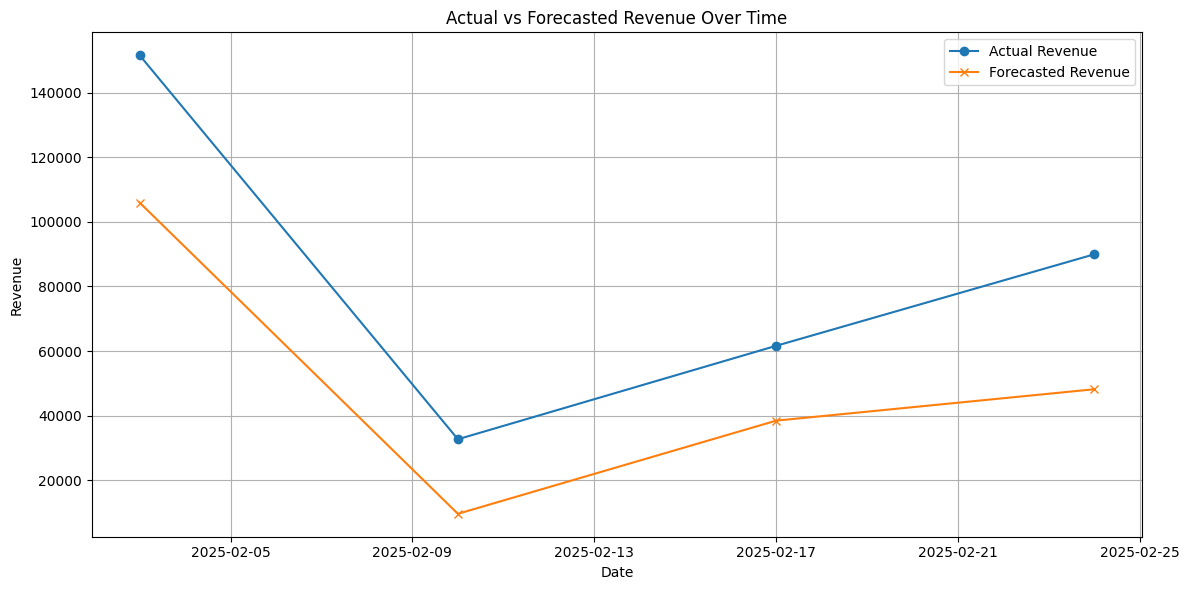

In [13]:
revenue_summary = results.groupby('ds').agg({
    'revenue': 'sum',
    'forecasted_revenue': 'sum'
}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(revenue_summary['ds'], revenue_summary['revenue'], marker='o', label='Actual Revenue')
plt.plot(revenue_summary['ds'], revenue_summary['forecasted_revenue'], marker='x', label='Forecasted Revenue')
plt.title('Actual vs Forecasted Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Завантаження прогнозу ретроспективи

In [14]:
results.to_csv('forecast_feb_2025_results.csv', index=False)
print("✅ Results saved to 'forecast_feb_2025_results.csv'")

✅ Results saved to 'forecast_feb_2025_results.csv'
